<a href="https://colab.research.google.com/github/Taleb10/BangalASR/blob/main/Attention%20%2B%20Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **==============NMT Using Attention============**

In [4]:
!pip install "tensorflow-text>=2.9.2"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.9 MB/s 
     |████████████████████████████████| 588.3 MB 20 kB/s 
     |████████████████████████████████| 439 kB 20.4 MB/s 
     |████████████████████████████████| 1.7 MB 6.7 MB/s 
     |████████████████████████████████| 6.0 MB 68.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [2]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [7]:
!cp /content/spa-eng.zip  /root/.keras/datasets

In [5]:
# !rm /root/.keras/datasets

In [6]:
# !mkdir /root/.keras/datasets

In [8]:
ls /root/.keras/datasets/

spa-eng.zip


In [9]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='/content/datasets/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [10]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return target, context

In [11]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

Doctor reza er schedule pawa jabe.


In [12]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [13]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Orthopaedic specialist k achen ekahne.' b'Zakir doctor kokhn boshen.'
 b'Doctor zakir koytay boshen.' b'Kon kon doctor achen.'
 b'Koto number room e doctor razia boshen.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Category two.' b'Category one.' b'Category one.' b'Category six.'
 b'Category three.'], shape=(5,), dtype=string)


***Standardization***

In [14]:
example_text = tf.constant('Doctor Zakir kokhn boshen')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'Doctor Zakir kokhn boshen'
b'Doctor Zakir kokhn boshen'


***Unicode Normalization***

In [15]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [16]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Doctor Zakir kokhn boshen
[START] doctor zakir kokhn boshen [END]


***Text Vectorization***

In [17]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [18]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['', '[UNK]', '[START]', '[END]', '.', 'doctor', 'kon', 'k', 'er', 'boshen']

In [19]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 'category',
 '[START]',
 '[END]',
 '.',
 'one',
 'two',
 'six',
 'seven']

In [20]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 23, 13, 7, 10, 28, 4, 3], [2, 12, 5, 27, 9, 4, 3],
 [2, 5, 12, 25, 9, 4, 3]]>

In [21]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] orthopaedic specialist k achen ekahne . [END]'

Text(0.5, 1.0, 'Mask')

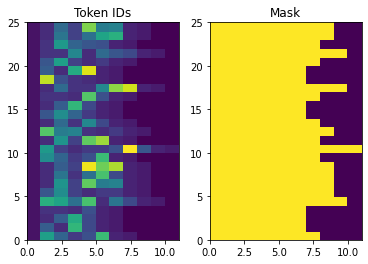

In [22]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

***Processing THe Dataset***

In [23]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [24]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[ 2 23 13  7 10 28  4  3  0  0]

[3 2 7 5]
[2 7 5 4]


***Encoder Decoder***

In [26]:
UNITS = 256

In [27]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [28]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (25, 11)
Encoder output, shape (batch, s, units): (25, 11, 256)


***Attention Layer***

In [29]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [30]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (25, 11, 256)
Target sequence, shape (batch, t, units): (25, 4, 256)
Attention result, shape (batch, t, units): (25, 4, 256)
Attention weights, shape (batch, t, s):    (25, 4, 11)


In [31]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.       , 1.       , 1.       , 1.0000001], dtype=float32)

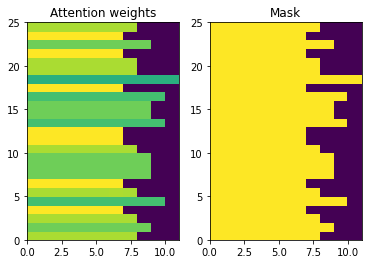

In [32]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


### ***The Decoder***

In [33]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

### ***Training***

In [34]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [35]:
decoder = Decoder(target_text_processor, UNITS)

In [36]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (25, 11, 256)
input target tokens shape: (batch, t) (25, 4)
logits shape shape: (batch, target_vocabulary_size) (25, 4, 13)


In [37]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [38]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [39]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

In [40]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'four  four six [UNK] [UNK]    ',
       b'five [UNK] . seven seven six four four seven .',
       b'[UNK] two one six five seven    '], dtype=object)

### ***The Model***

In [41]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [55]:
model_T = Translator(UNITS, context_text_processor, target_text_processor)

logits = model_T((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (25, 11)
Target tokens, shape: (batch, t) (25, 4)
logits, shape: (batch, t, target_vocabulary_size) (25, 4, 13)


In [56]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [57]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [58]:
model_T.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [59]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 2.5649493, 'expected_acc': 0.07692307692307693}

In [60]:
model_T.evaluate(val_ds, steps=20, return_dict=True)

 1/20 [>.............................] - ETA: 3:47 - loss: 3.0261 - masked_acc: 0.0833 - masked_loss: 3.0261

20/20 [==============================] - 12s 4ms/step - loss: 3.0261 - masked_acc: 0.0833 - masked_loss: 3.0261


{'loss': 3.026057481765747,
 'masked_acc': 0.0833333358168602,
 'masked_loss': 3.026057481765747}

In [61]:
history = model_T.fit(
    train_ds.repeat(), 
    epochs=10,
    steps_per_epoch = 10,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/10
 9/10 [==========================>...] - ETA: 0s - loss: 0.9922 - masked_acc: 0.7633 - masked_loss: 0.9922

10/10 [==============================] - 18s 40ms/step - loss: 0.9072 - masked_acc: 0.7870 - masked_loss: 0.9072 - val_loss: 0.2399 - val_masked_acc: 0.9167 - val_masked_loss: 0.2399
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0439 - masked_acc: 0.9960 - masked_loss: 0.0439

10/10 [==============================] - 0s 32ms/step - loss: 0.0439 - masked_acc: 0.9960 - masked_loss: 0.0439
Epoch 3/10
 9/10 [==========================>...] - ETA: 0s - loss: 0.0040 - masked_acc: 1.0000 - masked_loss: 0.0040

10/10 [==============================] - 0s 32ms/step - loss: 0.0038 - masked_acc: 1.0000 - masked_loss: 0.0038
Epoch 4/10
 9/10 [==========================>...] - ETA: 0s - loss: 0.0017 - masked_acc: 1.0000 - masked_loss: 0.0017

10/10 [==============================] - 0s 33ms/step - loss: 0.0016 - masked_acc: 1.0000 - masked_loss: 0.0016
Epoch 5/10
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - masked_acc: 1.0000 - masked_loss: 0.0010

10/10 [==============================] - 0s 32ms/step - loss: 9.8492e-04 - masked_acc: 1.0000 - masked_loss: 9.8492e-04
Epoch 6/10
 9/10 [==========================>...] - ETA: 0s - loss: 7.2255e-04 - masked_acc: 1.0000 - masked_loss: 7.2255e-04

10/10 [==============================] - 0s 32ms/step - loss: 7.1481e-04 - masked_acc: 1.0000 - masked_loss: 7.1481e-04
Epoch 7/10
 9/10 [==========================>...] - ETA: 0s - loss: 5.8958e-04 - masked_acc: 1.0000 - masked_loss: 5.8958e-04

10/10 [==============================] - 0s 34ms/step - loss: 5.8483e-04 - masked_acc: 1.0000 - masked_loss: 5.8483e-04
Epoch 8/10
 9/10 [==========================>...] - ETA: 0s - loss: 5.0544e-04 - masked_acc: 1.0000 - masked_loss: 5.0544e-04

10/10 [==============================] - 0s 32ms/step - loss: 5.0226e-04 - masked_acc: 1.0000 - masked_loss: 5.0226e-04
Epoch 9/10
 9/10 [==========================>...] - ETA: 0s - loss: 4.4826e-04 - masked_acc: 1.0000 - masked_loss: 4.4826e-04

10/10 [==============================] - 0s 32ms/step - loss: 4.4599e-04 - masked_acc: 1.0000 - masked_loss: 4.4599e-04
Epoch 10/10
 9/10 [==========================>...] - ETA: 0s - loss: 4.0631e-04 - masked_acc: 1.0000 - masked_loss: 4.0631e-04

10/10 [==============================] - 0s 33ms/step - loss: 4.0453e-04 - masked_acc: 1.0000 - masked_loss: 4.0453e-04


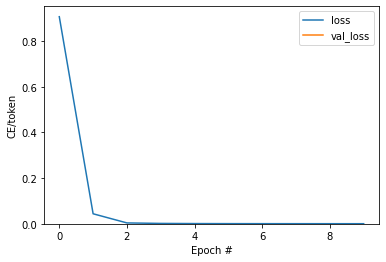

In [62]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

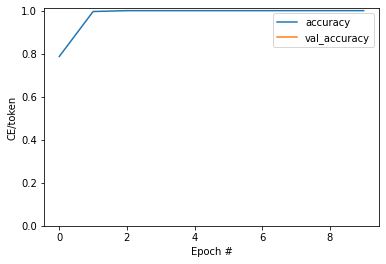

In [63]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### ***Translate***

In [64]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [65]:
result = model_T.translate(['Koto number room e doctor razia boshen.']) #Category three
result[0].numpy().decode()

'category three . '

In [66]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

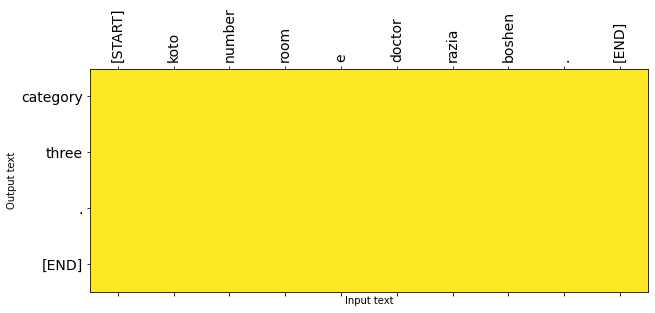

In [68]:
model_T.plot_attention('Koto number room e doctor razia boshen.') # 

In [86]:
import os
import sys
import pandas as pd
from IPython import display as ipd

import tensorflow as tf

tf.__version__

'2.11.0'

In [87]:
# !mkdir test-samples
# !mkdir test-samples/test_wav

In [164]:
# test audio sample
test_data = '/content/test-samples/test_data.tsv'

df=pd.read_csv('/content/test-samples/test_data.tsv',sep='\t')
# df = pd.read_csv(test_data)
print(df)

                     audio                        text
0  test_wav/191002t003.wav  doctor reza kon din boshen


In [165]:
# read sample audio and play it
wav_dir = '/content/test-samples/'
for i, d in df.iterrows():
    audio, text = os.path.join(wav_dir, d['audio']), d['text']
    print(f"text: {text}")
    ipd.display(ipd.Audio(audio))

text: doctor reza kon din boshen


In [166]:
# read character sets
chars_db_path = '/content/test-samples/chars_75.csv'

unique_chars = pd.read_csv(chars_db_path, skip_blank_lines=False)['chars']
unique_chars = unique_chars.to_list()

print(f"Total {len(unique_chars)} chars: {unique_chars}")

Total 53 chars: [' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [91]:
sys.path.append(os.path.abspath('/content/'))

In [135]:
max_target_len = 50

In [136]:

class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class SpeechFeatureEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return ffn_out_norm

    
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=10,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = SpeechFeatureEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes, activation='softmax')

    def decode(self, enc_out, target):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y)
        return y

    def call(self, inputs):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source)
        y = self.decode(x, target)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    @tf.function
    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        # print('test preds', preds.numpy)
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input


In [137]:

class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=27, target_end_token_idx=28
    ):
        """Displays a batch of outputs after every epoch

        Args:
            batch: A test batch containing the keys "source" and "target"
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 != 0:
            return
        self.batch = batch = next(iter(val_ds))
        source = self.batch["source"]
        target = self.batch["target"].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            # print("preds[i, :]", preds[i, :])
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}")


class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        init_lr=0.00001,
        lr_after_warmup=0.001,
        final_lr=0.00001,
        warmup_epochs=15,
        decay_epochs=85,
        steps_per_epoch=203,
    ):
        super().__init__()
        self.init_lr = init_lr
        self.lr_after_warmup = lr_after_warmup
        self.final_lr = final_lr
        self.warmup_epochs = warmup_epochs
        self.decay_epochs = decay_epochs
        self.steps_per_epoch = steps_per_epoch

    def calculate_lr(self, epoch):
        """ linear warm up - linear decay """
        warmup_lr = (
            self.init_lr
            + ((self.lr_after_warmup - self.init_lr) / (self.warmup_epochs - 1)) * epoch
        )
        decay_lr = tf.math.maximum(
            self.final_lr,
            self.lr_after_warmup
            - (epoch - self.warmup_epochs)
            * (self.lr_after_warmup - self.final_lr)
            / (self.decay_epochs),
        )
        lr =  tf.math.minimum(warmup_lr, decay_lr)
        return lr

    def __call__(self, step):
        epoch = step // self.steps_per_epoch
        return self.calculate_lr(epoch)


In [156]:
class VectorizeChar:
    def __init__(self, max_len=50):
        self.vocab = (
            ["-", "#", "<", ">"]
            + list(unique_chars)
            # + [chr(i + 96) for i in range(1, 27)]
            # + [" ", ".", ",", "?"]
        )
        self.max_len = max_len
        self.char_to_idx = {}
        for i, ch in enumerate(self.vocab):
            self.char_to_idx[ch] = i

    def __call__(self, text):
        # text = text.lower()
        text = text[: self.max_len - 2]
        text = "<" + text + ">"
        pad_len = self.max_len - len(text)
        return [self.char_to_idx.get(ch, 1) for ch in text] + [0] * pad_len

    def get_vocabulary(self):
        return self.vocab


# data = get_data(wavs, id_to_text, max_target_len)
vectorizer = VectorizeChar(max_target_len)
print("vocab size", len(vectorizer.get_vocabulary()))

def create_text_ds(data):
    texts = [_["text"] for _ in data]
    text_ds = [vectorizer(t) for t in texts]
    text_ds = tf.data.Dataset.from_tensor_slices(text_ds)
    return text_ds


def path_to_audio(path):
    # spectrogram using stft
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1)    
    # audio = tf.cast(tfio.audio.decode_flac(audio, dtype=tf.int16), tf.float32)
    audio = tf.squeeze(audio, axis=-1)
    stfts = tf.signal.stft(audio, frame_length=200, frame_step=80, fft_length=256)
    x = tf.math.pow(tf.abs(stfts), 0.5)
    audio_len = tf.shape(x)[0]
    # padding to 10 seconds
    pad_len = 1700 # 2754
    paddings = tf.constant([[0, pad_len], [0, 0]])
#     print('paddings shape:', tf.shape(paddings))
    x = tf.pad(x, paddings, "CONSTANT")[:pad_len, :]
#     print('final audio len:', tf.shape(x))
    return x


def create_audio_ds(data):
    flist = [_["audio"] for _ in data]
    audio_ds = tf.data.Dataset.from_tensor_slices(flist)
    audio_ds = audio_ds.map(
        path_to_audio, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    return audio_ds


# @tf.function
def create_tf_dataset(data, bs=4, val_data=False):
    audio_ds = create_audio_ds(data)
    text_ds = create_text_ds(data)
    ds = tf.data.Dataset.zip((audio_ds, text_ds))
    ds = ds.map(lambda x, y: {"source": x, "target": y})
    # cashe data to RAM 
    ds = ds.cache()
    # do shuffle
    ds = ds.shuffle(1000)
    ds = ds.batch(bs)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

data = data

# [T] modifie from 0.99 to 0.50
split = int(len(data) * 0.99)   
train_data = data # data[:split]
test_data =  data[split:]
# ds = create_tf_dataset(train_data, bs=400)
ds = create_tf_dataset(train_data, bs=64)
val_ds = create_tf_dataset(test_data, bs=64)

vocab size 57


In [157]:
# modified max target 30 to 46

max_target_len = 50
vectorizer = VectorizeChar(max_target_len)
print("vocab size", len(vectorizer.get_vocabulary()))

vocab size 57


In [158]:
model = Transformer(
    num_hid=128,
    num_head=2,
    num_feed_forward=256,
    target_maxlen=max_target_len,
    num_layers_enc=2,
    num_layers_dec=1,
    num_classes= 57  # modified 77 to 59 as per vocab size
)

In [159]:
model_checkpoint = '/content/'

# load checkpoint
latest = tf.train.latest_checkpoint(model_checkpoint)
model.load_weights(latest)

In [160]:
def predict(source, target_start_token_idx, target_maxlen):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = model.encoder(source)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(target_maxlen-1):
            dec_out = model.decode(enc, dec_input)
            logits = model.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

In [167]:
target_start_token_idx=2
target_end_token_idx = 3
idx_to_char = vectorizer.get_vocabulary()

for i, d in df.iterrows():
    # take audio and it's actual text
    audio, text = os.path.join(wav_dir, d['audio']), d['text']
    print(f"Sample [ {i+1} ] target text: {text}")
    print(f"Target audio: {audio}")
    ipd.display(ipd.Audio(audio))
    
    target_audio = path_to_audio(audio)
    target_audio = tf.expand_dims(target_audio, 0)
    # perform prediction on given target audio file
    preds = predict(target_audio, target_start_token_idx, target_maxlen=max_target_len)
    
    preds = preds.numpy()[0]
    prediction = []
    for idx in preds:
        prediction.append(idx_to_char[idx])
        if idx == target_end_token_idx:
            break
    
    prediction = ''.join(prediction)
    print(f"prediction: {prediction}")
    print('-'*50)

Sample [ 1 ] target text: doctor reza kon din boshen
Target audio: /content/test-samples/test_wav/191002t003.wav


prediction: <cardiology specialist k achen ekhane>
--------------------------------------------------


In [168]:
print(prediction)

<cardiology specialist k achen ekhane>


In [170]:
FILTER_CHARS = [
    '"', '%', "'", ',', '-', '.', '/', '>', '\x94', '\u200c', '\u200d', '‘', 
    '’', '“', '”', '…', '!', ':', ';', '?', '<', '।', '–'
]

def clean(text):
    '''Clean text'''
    for c in FILTER_CHARS:
        if c in text:
            text = text.replace(c, '')
    return text

Result = clean(prediction)

In [171]:
print(Result)

cardiology specialist k achen ekhane


In [172]:
# result = model_T.translate(['Koto number room e doctor razia boshen.']) #Category three
# result[0].numpy().decode()

result = model_T.translate([Result]) #Category three
result[0].numpy().decode()

'category five . '